## TODO: 
* ROUND BEFORE CLUSTERING!!! (Done!)
* Unbias dataset from the excessive number of hexagonal examples?
* Visualize how often a given node or edge is present by size of node or edge

In [370]:
from pymongo import MongoClient
from sklearn.cluster import KMeans
from symmetry_finding import norm_sph
import numpy as np
import pandas as pd
import networkx as nx
import ast
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from networkx.drawing.nx_pydot import write_dot
from frozendict import frozendict
import math
import scipy
import random
from symmetry_finding import ylms_within_r_cutoff
from functools import partial
%matplotlib inline

In [2]:
def norm_values(dict_of_spherical_harm):
    new_dict = {}
    for key, value in dict_of_spherical_harm.items():
        new_dict[ast.literal_eval(key)] =  norm_sph(np.array(value).reshape(-1, 36))[0]
    return new_dict

def edge_clusters(dict_of_edge_norms):
    new_dict = {}
    for key,value in dict_of_edge_norms.items():
        new_dict[key] = kmeans_edge_norm.predict(value.reshape(1,-1))[0]
    return new_dict

def make_cluster_graph(row):
    new_dict = {}
    if len(row['edge_clusters']):
        for key, value in row['edge_clusters'].items():
            new_key = tuple(sorted((row['sites_clusters'][key[0]], 
                                    row['sites_clusters'][key[1]])))
            if new_key not in new_dict:
                new_dict[new_key] = []
            new_dict[new_key].append(value)
    return new_dict

def get_unique_edges_given_cluster_tuple(cluster_tuple, df):
    return set(np.concatenate(df['cluster_graph'].apply(
        lambda x: x.get(cluster_tuple)).dropna().reset_index()['cluster_graph']))

def get_unique_cluster_tuples(df):
    edge_keys = df['cluster_graph'].apply(lambda x: list(x.keys()))
    cluster_list = []
    edge_keys.where(edge_keys.apply(
        lambda x: len(x)) > 0).dropna().reset_index()['cluster_graph'].apply(cluster_list.extend)
    return set(cluster_list)

In [3]:
db = MongoClient().linus.lattices

In [4]:
df = pd.DataFrame(list(db.find({'sites': {'$exists': True}}).limit(1000)))

In [5]:
df['sites_norm'] = df['sites'].apply(np.array).apply(norm_sph)
df['edges_norm'] = df['edges'].apply(norm_values)

In [6]:
edge_norm_values = df['edges_norm'].apply(lambda x: list(x.values()))
edge_norm_data = np.concatenate(
    edge_norm_values.where(
        edge_norm_values.apply(lambda x: len(x) > 0)).dropna().reset_index()['edges_norm'])
node_norm_data = np.concatenate(df['sites_norm'])

# ROUND! It makes for better clustering.
node_norm_data = np.round(node_norm_data, 4)
edge_norm_data = np.round(edge_norm_data, 4)

In [7]:
print(node_norm_data.shape, edge_norm_data.shape)

(15908, 6) (70430, 6)


In [8]:
N_node_clusters = 20
N_edge_clusters = 100
kmeans_norm = KMeans(n_clusters=N_node_clusters, random_state=0).fit(node_norm_data)
kmeans_edge_norm = KMeans(n_clusters=N_edge_clusters, random_state=0).fit(edge_norm_data)

In [9]:
df['sites_clusters'] = df['sites_norm'].apply(kmeans_norm.predict)
df['edge_clusters'] = df['edges_norm'].apply(edge_clusters)
df['cluster_graph'] = df.apply(make_cluster_graph, axis=1)

In [10]:
total_graph = {}
for cluster_tuple in get_unique_cluster_tuples(df):
    total_graph[cluster_tuple] = get_unique_edges_given_cluster_tuple(cluster_tuple, df)

In [11]:
node_color_map = matplotlib.colors.Normalize(vmin=0, vmax=N_node_clusters-1)
edge_color_map = matplotlib.colors.Normalize(vmin=0, vmax=N_edge_clusters-1)
node_cluster_color = lambda x: matplotlib.colors.rgb2hex(cm.rainbow(node_color_map(x))[:3])
edge_cluster_color = lambda x: matplotlib.colors.rgb2hex(cm.rainbow(edge_color_map(x))[:3])

In [28]:
cluster_graph = nx.MultiGraph()

In [29]:
for node in set(np.concatenate(list(total_graph.keys()))):
    cluster_graph.add_node(node, fillcolor=node_cluster_color(node), style="filled")

In [30]:
for edge, edge_clusters in total_graph.items():
    start, end = edge
    for clusters in edge_clusters:
        cluster_graph.add_edge(start, end, color=edge_cluster_color(clusters), edge_cluster=clusters)

In [33]:
dot = nx.nx_pydot.to_pydot(cluster_graph)

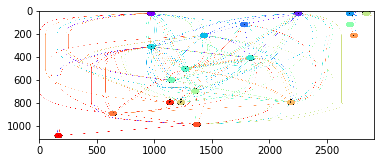

In [119]:
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

png_str = dot.create_png(prog='dot')
bio = BytesIO(png_str)
bio.seek(0)
img = mpimg.imread(bio)

# plot the image
imgplot = plt.imshow(img, aspect='equal')
plt.show(block=False)

In [35]:
dot.write_pdf("total_graph.pdf")

True

### Now, we want to show examples from site and edge clusters.
To do this we need to be able to get examples of sites and edges belonging to a specific cluster.

## TODO:
* Be able to select coordinates from lattices using the indices gathered from these commands 
* Plot some random subset up to 50 examples

In [154]:
# TODO: Panda-ify this
def get_motifs_for_site_cluster(cluster_number, df):
    sites_clusters_df = pd.DataFrame((item for item in df['sites_clusters']))
    x = sites_clusters_df[sites_clusters_df == cluster_number].notnull()
    return list(x[x > 0].stack().index)

In [166]:
# TODO: Panda-ify this
def get_motifs_for_edge_cluster(cluster_number, df):
    edge_clusters_df = pd.DataFrame([
        {
            'lattice': i, 'edge': key, 'edge_cluster': value
        } for i,item in zip(df['edge_clusters'].index, df['edge_clusters']) for key, value in item.items()])
    indices = edge_clusters_df.where(edge_clusters_df['edge_cluster'] == cluster_number).dropna()
    return list(zip(indices['lattice'].apply(int), indices['edge']))

In [159]:
def get_local_env(struct, atom, cutoff):
    origin = df['coords'][struct][atom]
    return list(filter(lambda x: np.linalg.norm(np.array(x) - np.array(origin), axis=-1) < cutoff, df['coords'][struct]))

In [170]:
def get_local_env_edge(struct, atom1, atom2, cutoff):
    origin1 = df['coords'][struct][atom1]
    origin2 = df['coords'][struct][atom2]
    return list(
        filter(lambda x: (np.linalg.norm(np.array(x) - np.array(origin1), axis=-1) < cutoff) or \
                         (np.linalg.norm(np.array(x) - np.array(origin2), axis=-1) < cutoff),
               df['coords'][struct])
    )

In [160]:
def color_by_numbers(numbers, nmin=0, nmax=None, cmap=None):
    cmap = cm.rainbow if not cmap else cmap
    nmax = max(numbers) if not nmax else nmax
    colors = [cm.rainbow(float((n - nmin))/float(nmax)) for n in numbers]
    return colors

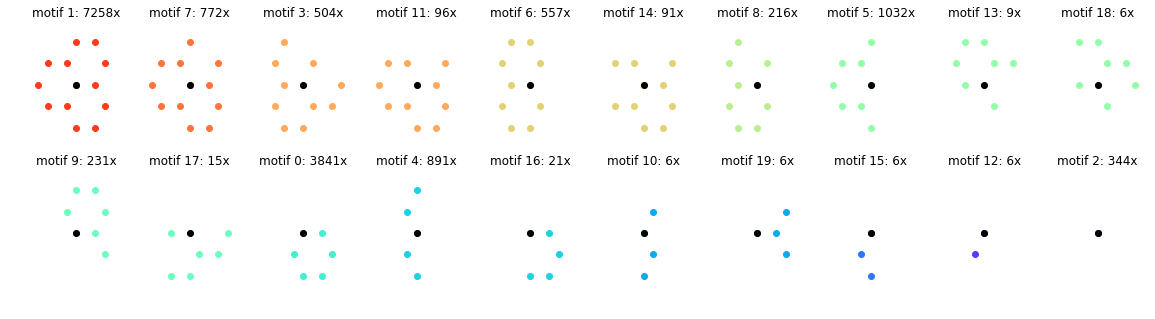

In [178]:
# Plot and sort by number of atoms in motif
coords = []
structs = []
atoms = []
occurances = []
motifs = list(range(N_node_clusters))
for i in range(N_node_clusters):
    motif_dict = get_motifs_for_site_cluster(i, df)
    if len(motif_dict):
#         print(motif_dict[0])
        struct, atom = motif_dict[0]
        coord = np.array(get_local_env(struct, atom, 5.0))
        adjusted_coord = coord - np.array(df['coords'][struct][atom])
        coords.append(adjusted_coord)
        structs.append(struct)
        atoms.append(atom)
        occurances.append(len(motif_dict))
    else:
        pass

coords, structs, atoms, motifs, occurances = zip(*sorted(zip(coords, structs, atoms, motifs, occurances), key=lambda x: -len(x[0])))
    
fig, axes = plt.subplots(math.ceil(len(motifs) / 10), 10, figsize=(20, 2.5 * math.ceil(len(motifs) / 10)))
axes = axes.flatten()
col_len = [coord.shape[0] for coord in coords]
colors = color_by_numbers(col_len, nmin=min(col_len), nmax=max(col_len))
for i in range(len(motifs)):
    axes[i].scatter(coords[i][:,0],
                    coords[i][:,1],
                    c=[colors[i]])
    axes[i].scatter([0.], [0.], c='k')
    axes[i].set_xlim([-5, 5])
    axes[i].set_ylim([-5, 5])
    axes[i].set_axis_off()
    axes[i].set_title("motif {}: ".format(motifs[i]) + str(occurances[i]) + "x")

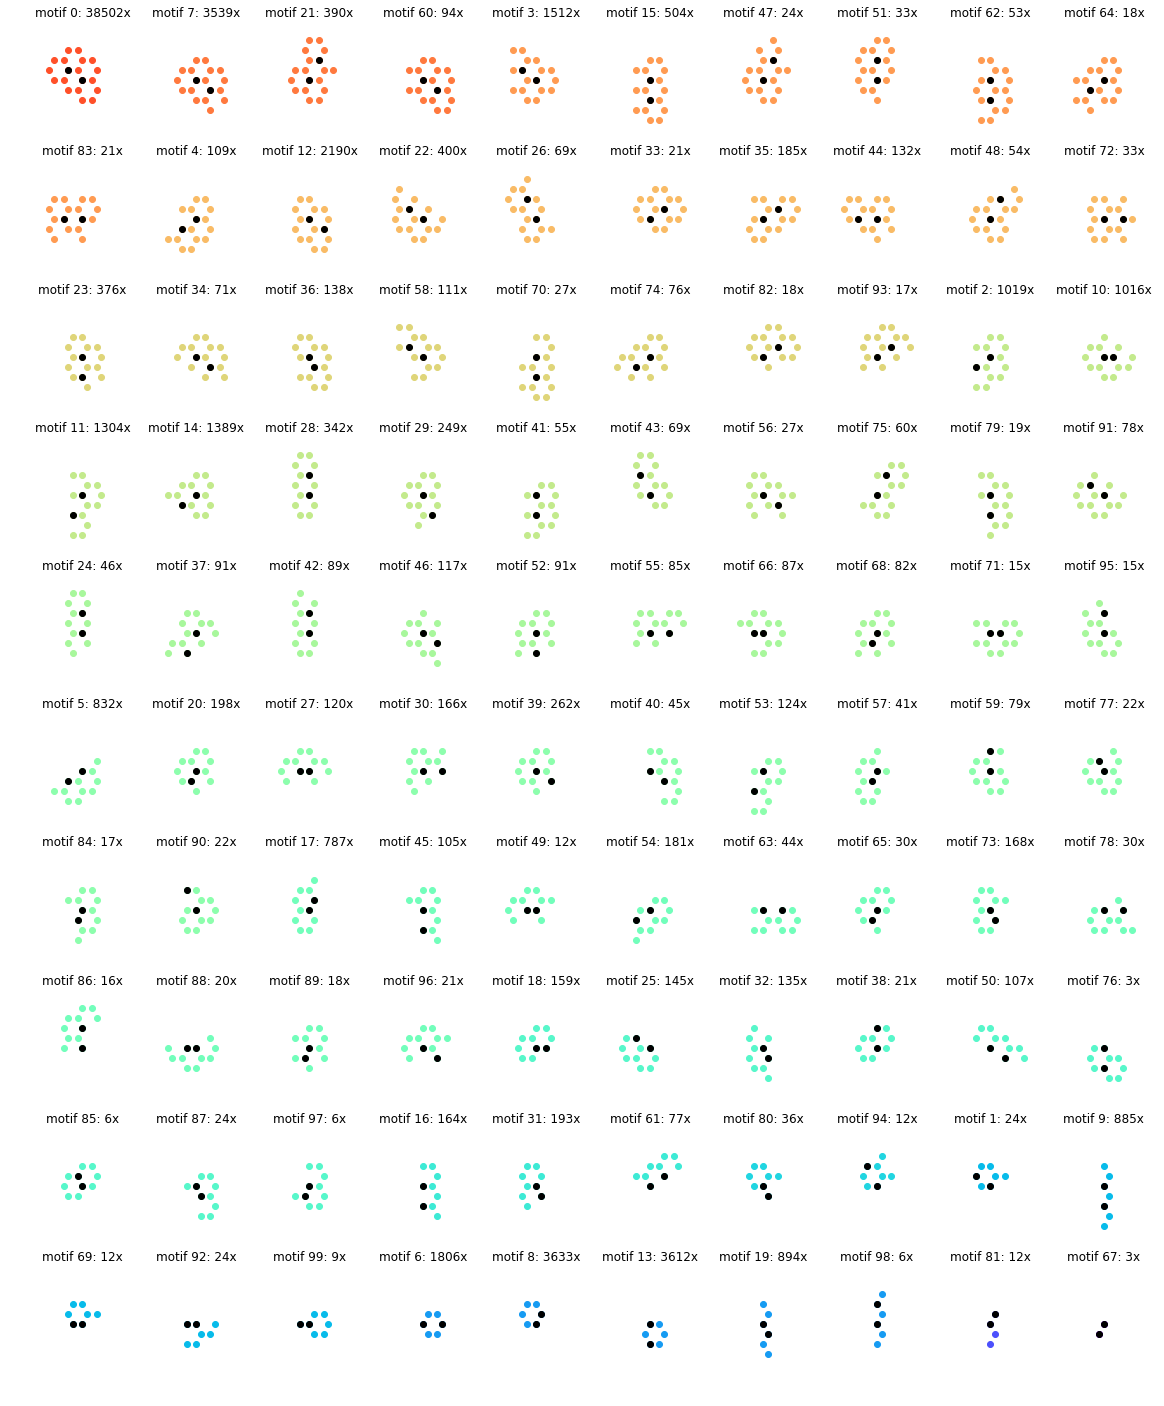

In [177]:
# Plot and sort by number of atoms in motif
coords = []
structs = []
atoms = []
occurances = []
motifs = list(range(N_edge_clusters))
for i in range(N_edge_clusters):
    motif_dict = get_motifs_for_edge_cluster(i, df)
    if len(motif_dict):
#         print(motif_dict[0])
        struct, (atom1, atom2) = motif_dict[0]
        coord = np.array(get_local_env_edge(struct, atom1, atom2, 5.0))
        adjusted_coord = coord - np.array(df['coords'][struct][atom1])
        coords.append(adjusted_coord)
        structs.append(struct)
        atoms.append((atom1, atom2))
        occurances.append(len(motif_dict))
    else:
        pass

coords, structs, atoms, motifs, occurances = zip(*sorted(zip(coords, structs, atoms, motifs, occurances), key=lambda x: -len(x[0])))
    
fig, axes = plt.subplots(math.ceil(len(motifs) / 10), 10, figsize=(20, 2.5 * math.ceil(len(motifs) / 10)))
axes = axes.flatten()
col_len = [coord.shape[0] for coord in coords]
colors = color_by_numbers(col_len, nmin=min(col_len), nmax=max(col_len))
for i in range(len(motifs)):
    axes[i].scatter(coords[i][:,0],
                    coords[i][:,1],
                    c=[colors[i]])
    atom1, atom2 = atoms[i]
    origin = np.array(df['coords'][structs[i]][atom1])
    second_atom = np.array(df['coords'][structs[i]][atom2]) - origin
    # Show centers
    axes[i].scatter([0., second_atom[0]], [0., second_atom[1]], c='k')
    axes[i].set_xlim([-10, 10])
    axes[i].set_ylim([-10, 10])
    axes[i].set_axis_off()
    axes[i].set_title("motif {}: ".format(motifs[i]) + str(occurances[i]) + "x")

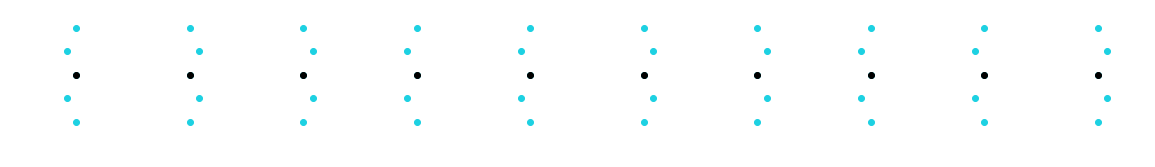

In [301]:
N_motif = 4
N_show = 10
motif = get_motifs_for_site_cluster(N_motif, df)[:N_show]
fig, axes = plt.subplots(math.ceil(len(motif) / 10), 
                         10, 
                         figsize=(20, 2.5 * math.ceil(len(motif) / 10)))
axes = axes.flatten()
for axis in axes:
    axis.set_axis_off()
for i in range(len(motif)):
    struct, atom = motif[i]
    coord = np.array(get_local_env(struct, atom, 5.0))
    color = color_by_numbers([len(coord)], nmin=1, nmax=13)
    adjusted_coord = coord - np.array(df['coords'][struct][atom])
    axes[i].scatter(*zip(*adjusted_coord), c=color)
    axes[i].scatter([0], [0], c='k')
    axes[i].set_axis_off()
    axes[i].set_xlim([-5, 5])
    axes[i].set_ylim([-5, 5])

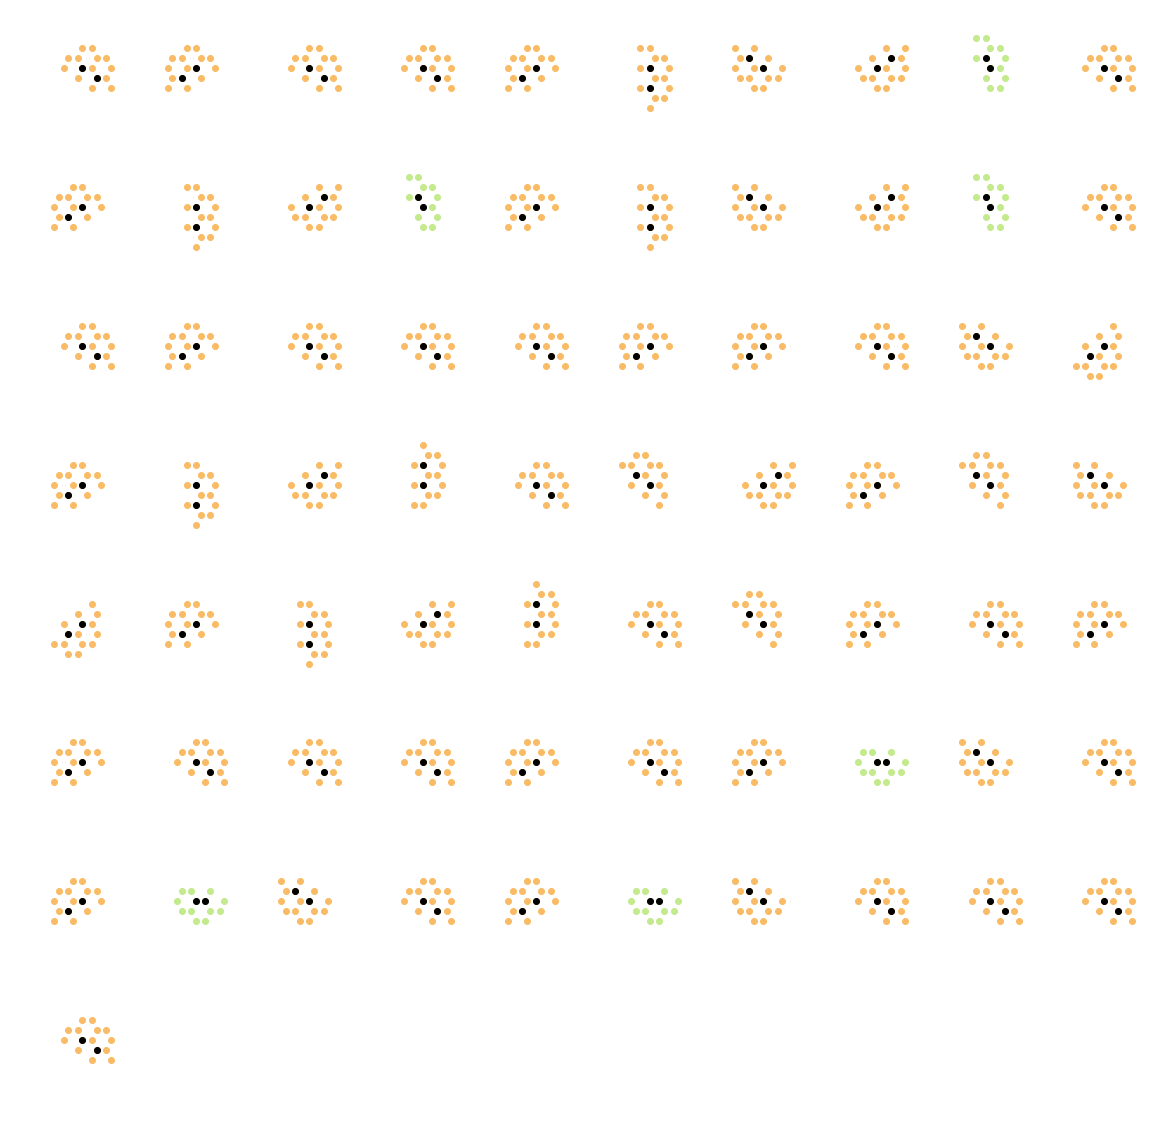

In [251]:
N_motif = 34
motif = get_motifs_for_edge_cluster(N_motif, df)[:100]
fig, axes = plt.subplots(math.ceil(len(motif) / 10), 
                         10, 
                         figsize=(20, 2.5 * math.ceil(len(motif) / 10)))
axes = axes.flatten()
for axis in axes:
    axis.set_axis_off()
for i in range(len(motif)):
    struct, (atom1, atom2) = motif[i]
    origin = np.array(df['coords'][struct][atom1])
    second_atom = np.array(df['coords'][struct][atom2]) - origin
    
    coord = np.array(get_local_env_edge(struct, atom1, atom2, 5.0))
    color = color_by_numbers([len(coord)], nmin=1, nmax=19)
    adjusted_coord = coord - np.array(df['coords'][struct][atom1])
    axes[i].scatter(*zip(*adjusted_coord), c=color)
    # Show centers
    axes[i].scatter([0., second_atom[0]], [0., second_atom[1]], c='k')
    axes[i].set_axis_off()
    axes[i].set_xlim([-10, 10])
    axes[i].set_ylim([-10, 10])

In [390]:
def rotation_matrix(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis * theta))

# Since linus is constrained
def generate_all_orientations(coords_from_origin):
    # 120 degree rotation
    rot120 = rotation_matrix(np.array([0,0,1]), 2 * np.pi / 3)[:2, :2]
    # 240 degree rotation
    rot240 = rotation_matrix(np.array([0,0,1]), 4 * np.pi / 3)[:2, :2]
    all_orientations = [
        np.array(coords_from_origin),  # identity
        np.einsum('xy,by->bx', rot120, coords_from_origin),  # 120 degree
        np.einsum('xy,by->bx', rot240, coords_from_origin),  # 240 degree
        -1 * np.array(coords_from_origin)  # 2d inversion
    ]
    return np.array(all_orientations)

In [391]:
from crystal_graph import TensorProduct

In [392]:
tp = TensorProduct(5,5,5)

In [418]:
n_iter = 0
n_iter_max = 5
r_cutoff = 5.
L_max = 5

build_coords = []
build_motifs = []
# build_sph = [] 
to_be_processed = []

coord, cluster = np.array([0., 0.]), 4
build_coords.append(coord)
build_motifs.append(cluster)
to_be_processed.append((cluster, coord))

while len(to_be_processed) > 0 and n_iter < n_iter_max:
#     print(to_be_processed)
    n_iter += 1
    cluster, origin = to_be_processed.pop(0) # queue
    
    # get template motif
    struct, atom = random.choice(get_motifs_for_site_cluster(cluster, df))
    cluster_origin = df['coords'][struct][atom]
    
    # get local environment from template
    dist_M = np.linalg.norm(df['coords'][struct] - np.array(df['coords'][struct][atom]), axis=-1)
    neighbors = np.where((dist_M < r_cutoff) & (dist_M > 0))
    env = np.array(df['coords'][struct])[neighbors] - cluster_origin
    motifs = df['sites_clusters'][struct][neighbors]
    
    # Now to figure out rotation of motifs that is most appropriate
    cur_dist_M = np.linalg.norm(np.array(build_coords) - origin, axis=-1)
    cur_neighbors = np.where((cur_dist_M < r_cutoff) & (cur_dist_M > 0))[0] # indices
#     print(cur_neighbors)
    
    # if no neighbors
    if len(cur_neighbors) == 0:
        build_coords.extend(np.array(env).tolist())
        build_motifs.extend(motifs)
        to_be_processed.extend(zip(motifs, env))
    else:
        # Check which rotation is compatible
        cur_env = np.array(build_motifs)[cur_neighbors]
        cur_neighbor_coords = (np.array(build_coords) - origin)[cur_neighbors]
        print("env: ", env)
        possible_envs = generate_all_orientations(env)
        # perform convolution of env with possible env
        M, N, _ = possible_envs.shape
        possible_envs_coords = np.concatenate((possible_envs, np.zeros([M, N, 1])), axis=-1)
        print(possible_envs_coords.shape)
        get_sph = partial(ylms_within_r_cutoff, r_cutoff=r_cutoff, L_max=L_max)
        get_sph_sum = lambda x: get_sph(x)[0].sum(axis=-1)
        print("possible_envs: ", possible_envs_coords)
        possible_sph = list(map(get_sph_sum, possible_envs_coords))
        
        N, _ = cur_neighbor_coords.shape
        cur_sph = get_sph_sum(np.concatenate((cur_neighbor_coords, np.zeros([N, 1])), axis=-1))
        best_possible_env = np.argmax(np.einsum('bx,x->b', np.array(possible_sph), cur_sph))
        
        # ALMOST THERE
        # Get best enviroment
        # possible_env[best_possible_env]
        # Leave out atoms that are already there
        # Add new atom motifs and coords to build_coords and build_motifs
        # Add new atom to to_be_processed queue

env:  [[-3.    -1.732]
 [-1.    -1.732]
 [ 2.     0.   ]
 [ 3.     1.732]]
(4, 4, 3)
possible_envs:  [[[-3.00000000e+00 -1.73200000e+00  0.00000000e+00]
  [-1.00000000e+00 -1.73200000e+00  0.00000000e+00]
  [ 2.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 3.00000000e+00  1.73200000e+00  0.00000000e+00]]

 [[ 2.99995600e+00 -1.73207621e+00  0.00000000e+00]
  [ 1.99995600e+00 -2.54037844e-05  0.00000000e+00]
  [-1.00000000e+00  1.73205081e+00  0.00000000e+00]
  [-2.99995600e+00  1.73207621e+00  0.00000000e+00]]

 [[ 4.40006454e-05  3.46407621e+00  0.00000000e+00]
  [-9.99955999e-01  1.73202540e+00  0.00000000e+00]
  [-1.00000000e+00 -1.73205081e+00  0.00000000e+00]
  [-4.40006454e-05 -3.46407621e+00  0.00000000e+00]]

 [[ 3.00000000e+00  1.73200000e+00  0.00000000e+00]
  [ 1.00000000e+00  1.73200000e+00  0.00000000e+00]
  [-2.00000000e+00 -0.00000000e+00  0.00000000e+00]
  [-3.00000000e+00 -1.73200000e+00  0.00000000e+00]]]
[array([ 1.12837917e+00, -2.44295881e-01,  0.00000000e+00, 

env:  [[ 0.    -3.464]
 [-1.    -1.732]
 [-1.     1.732]
 [ 0.     3.464]]
(4, 4, 3)
possible_envs:  [[[ 0.00000000e+00 -3.46400000e+00  0.00000000e+00]
  [-1.00000000e+00 -1.73200000e+00  0.00000000e+00]
  [-1.00000000e+00  1.73200000e+00  0.00000000e+00]
  [ 0.00000000e+00  3.46400000e+00  0.00000000e+00]]

 [[ 2.99991200e+00  1.73200000e+00  0.00000000e+00]
  [ 1.99995600e+00 -2.54037844e-05  0.00000000e+00]
  [-9.99955999e-01 -1.73202540e+00  0.00000000e+00]
  [-2.99991200e+00 -1.73200000e+00  0.00000000e+00]]

 [[-2.99991200e+00  1.73200000e+00  0.00000000e+00]
  [-9.99955999e-01  1.73202540e+00  0.00000000e+00]
  [ 1.99995600e+00  2.54037844e-05  0.00000000e+00]
  [ 2.99991200e+00 -1.73200000e+00  0.00000000e+00]]

 [[-0.00000000e+00  3.46400000e+00  0.00000000e+00]
  [ 1.00000000e+00  1.73200000e+00  0.00000000e+00]
  [ 1.00000000e+00 -1.73200000e+00  0.00000000e+00]
  [-0.00000000e+00 -3.46400000e+00  0.00000000e+00]]]
[array([ 1.12837917e+00,  4.88613262e-01,  0.00000000e+00, 

2
